In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

## User input

In [19]:
filename_prefix = 'E:\\Ashlee\\PacBio\\181207\\blank\\m181207_203634_42131_c000468672559900001500000112312090_s1_p0'
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy35', 'Cy5', 'Cy55']

## Load data

In [3]:
trc_filename = filename_prefix + '.trc.h5'
mcd_filename = filename_prefix + '.mcd.h5'
upd_filename = filename_prefix + '.upd.h5'
meta_filename = filename_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

time_axis = np.arange(n_frames)*frame_rate # for plotting traces

## View data structure
def printname(name):
    print(name)

print('In mcd file: ')
mcd_file.visit(printname)
print()

print('In upd file: ')
upd_file.visit(printname)

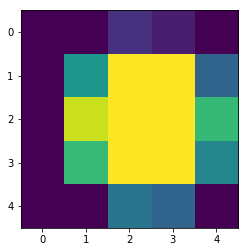

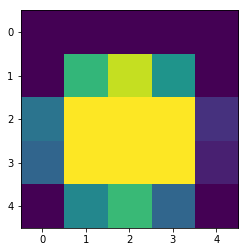

In [4]:
psf = mcd_file['MovieCal']['Camera[0]']['Psf']
for i in range(1, 3):
    fig, ax = plt.subplots()
    im = ax.imshow(psf[0, i, :, :])

## Decode trace intensities

In [4]:
traces = np.zeros(raw_traces.shape)
for i in range(n_traces):
    traces[i] = decode_array[raw_traces[i]]

## Plot intensity distributions

In [5]:
avg_intens = np.mean(traces, axis=2) # not decoded

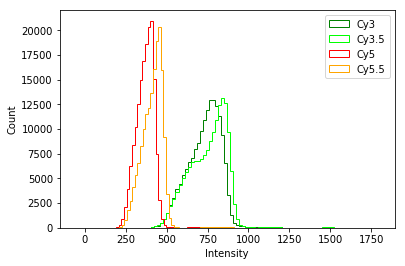

In [6]:
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = 1800
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.legend(lasers)

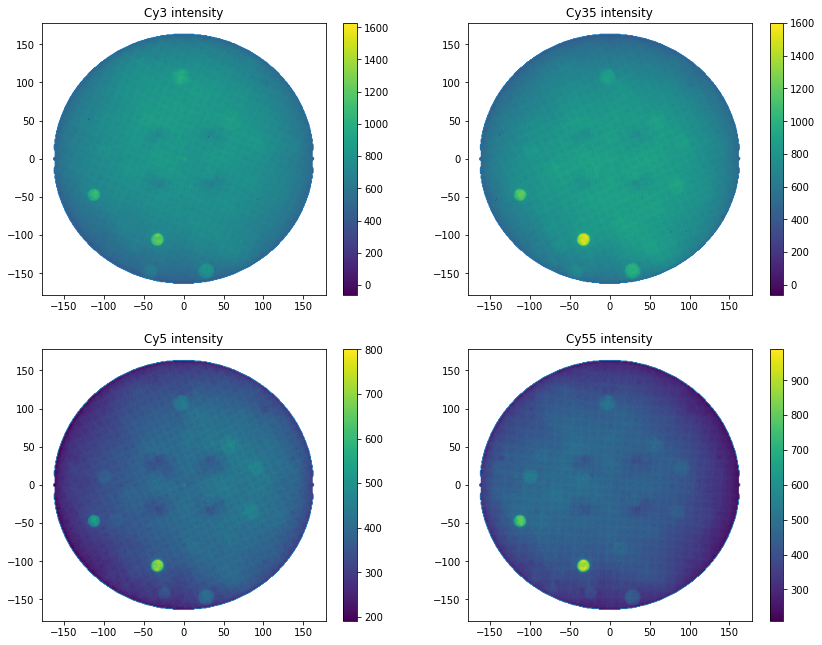

In [26]:
plt.figure(figsize=(14, 11))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()

plt.savefig(filename_prefix + '_grid.png')
plt.show()

## View a trace

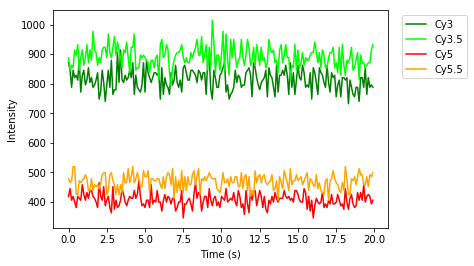

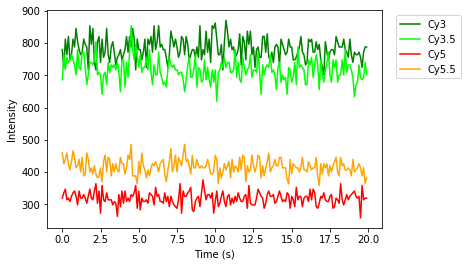

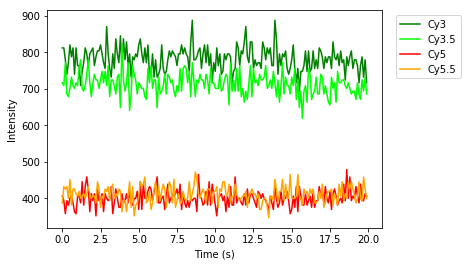

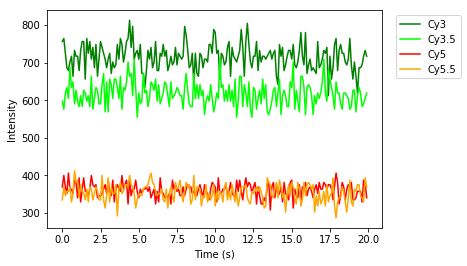

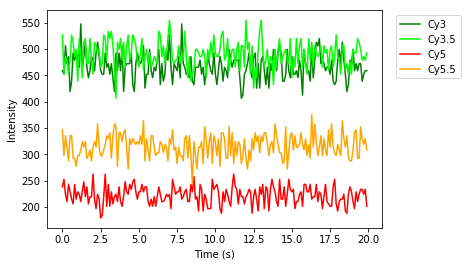

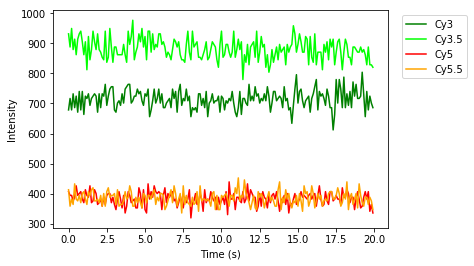

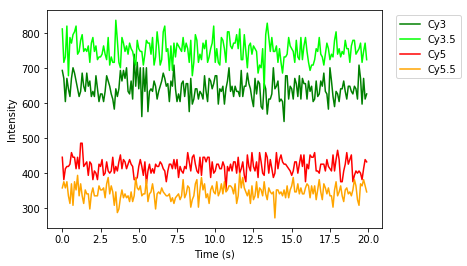

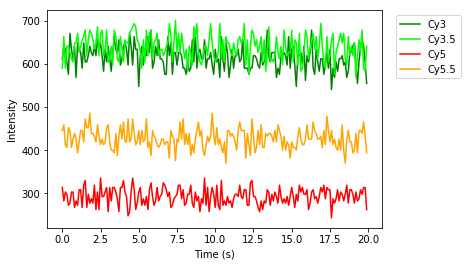

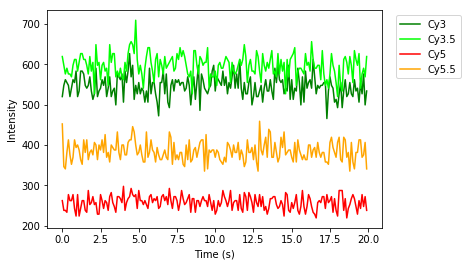

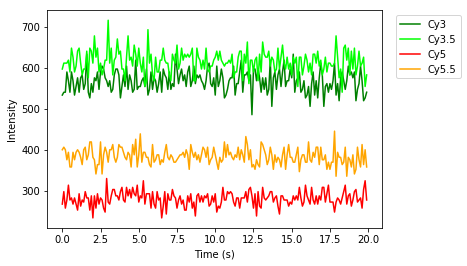

In [18]:
#i = 112542 # is a good example
for j in range(10):
    i = np.random.randint(0, 163481)
    trace = traces[i]
    plt.figure()
    for i in range(4):
        plt.plot(time_axis, trace[i], color=colors[i])
        i += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

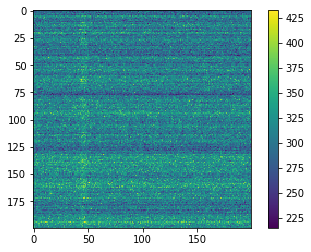

In [29]:
plt.imshow(traces[:200, 2, :])
plt.colorbar()

Text(0,0.5,'Wells')

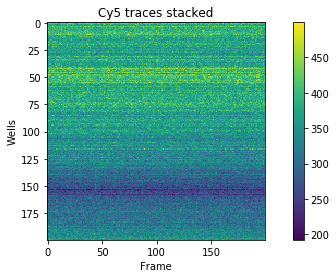

In [32]:
plt.figure(figsize=(10, 4))
plt.imshow(traces[(112542-100):(112542+100), 2, :])
plt.colorbar()
plt.title("Cy5 traces stacked")
plt.xlabel("Frame")
plt.ylabel('Wells')
# plt.savefig(filename_prefix + '_cy5_stacked_example.png', dpi=300)

## Plot average intensity over time for each color

In [10]:
avg_trace = np.zeros((4, 200))
for i in range(4):
    avg_trace[i] = np.mean(traces[:][:][i], axis=0)

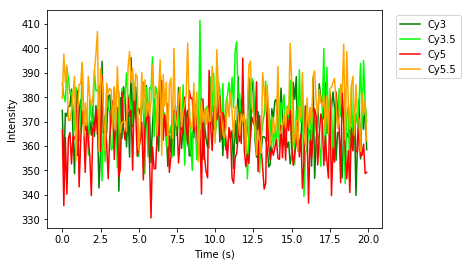

In [11]:
for i in range(4):
    plt.plot(time_axis, avg_trace[i], color=colors[i])

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))